<a href="https://colab.research.google.com/github/simeonubi/Disaster_classifier-/blob/main/Disaster_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -qq transformers

     |████████████████████████████████| 1.5MB 12.8MB/s 
     |████████████████████████████████| 2.9MB 58.3MB/s 
     |████████████████████████████████| 890kB 51.3MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Bidirectional Encoder Representations from Transformers(BERT) in Pytorch**

BERT makes use of Transformer, an attention mechanism that learns contextual relations between words (or sub-words) in a text. In its vanilla form, Transformer includes two separate mechanisms — an encoder that reads the text input and a decoder that produces a prediction for the task.

In [ ]:

import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 8, 6

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Disaster data/Assignment NLP Data/train.csv')
test_df = pd.read_csv('/content/drive/My Drive/Disaster data/Assignment NLP Data/test.csv')

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
sample_txt = "I can't go out because of corona virus"

In [ ]:
tokens = tokenizer.tokenize(sample_txt)

In [ ]:
print(tokens)

['I', 'can', "'", 't', 'go', 'out', 'because', 'of', 'co', '##rona', 'virus']


In [ ]:
tokens_id = tokenizer.convert_tokens_to_ids(tokens)

In [ ]:
print(f"sentence : {sample_txt}")
print(f"tokens : {tokens}")
print(f"sentence : {token_id}")

In [ ]:
#tokenize each sentence and append to a list
token_lens = []

for txt in df.text:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

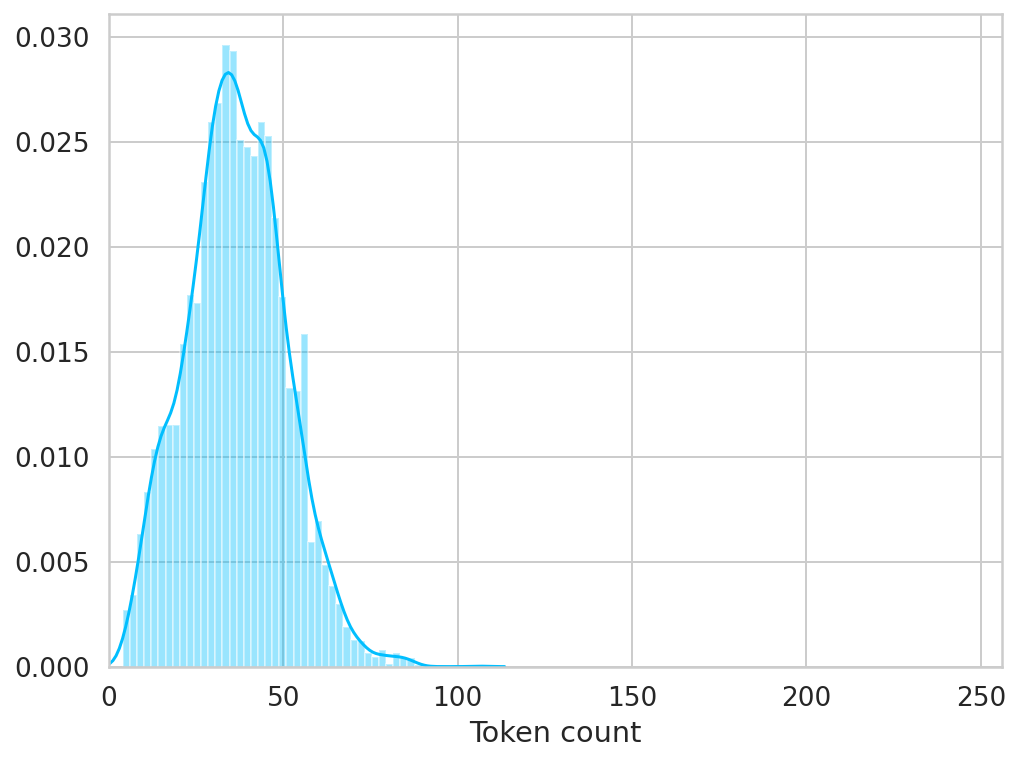

In [ ]:

sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [ ]:
MAX_LEN = 60

In [ ]:
#econding your input
class DSTweetDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
class_names = ['Disaster', 'Not_Disaster']

In [ ]:
#split data into train validation and test
df_train, df_test = train_test_split(
  df,
  test_size=0.20,
  random_state=RANDOM_SEED
)
df_val, df_test = train_test_split(
  df_test,
  test_size=0.5,
  random_state=RANDOM_SEED
)

In [ ]:
df_train.shape, df_val.shape, df_test.shape

In [ ]:
#creates data pipeline for the model and converts to numpy array with a batch size
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = DSTweetDataset(
    reviews=df.text.to_numpy(),
    targets=df.target.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 60])
torch.Size([16, 60])
torch.Size([16])


In [ ]:
#downloads the bert pretrained model
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
#creates trainig class
class DisasterClassifier(nn.Module):

  def __init__(self, n_classes):
    super(DisasterClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
#initialize class
model = DisasterClassifier(len(class_names))
model = model.to(device)

In [ ]:
#creates optimiztion and loss function
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
#training loop
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
#evaluation loop
def eval_model(model, data_loader, loss_fn, confusion_report, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

      print("Confusion Report: " classification_report(target, preds) )

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
#training
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------


/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


Train loss 0.4994824082245977 accuracy 0.7801313628899836
Val   loss 0.4696324473867814 accuracy 0.8055190538764784

Epoch 2/10
----------
Train loss 0.3325321582632428 accuracy 0.8755336617405584
Val   loss 0.47159952980776626 accuracy 0.8028909329829172

Epoch 3/10
----------
Train loss 0.2170316621348301 accuracy 0.9343185550082103
Val   loss 0.6988239396984378 accuracy 0.7950065703022339

Epoch 4/10
----------
Train loss 0.15636234467340696 accuracy 0.9574712643678162
Val   loss 0.9135391009040177 accuracy 0.783180026281209

Epoch 5/10
----------
Train loss 0.11744139166952176 accuracy 0.9673234811165846
Val   loss 1.0346557831702132 accuracy 0.7936925098554534

Epoch 6/10
----------
Train loss 0.08575630681638134 accuracy 0.9763546798029556
Val   loss 1.0900327002163976 accuracy 0.7792378449408673

Epoch 7/10
----------
Train loss 0.0701014422084354 accuracy 0.9816091954022989
Val   loss 1.2112968489527702 accuracy 0.7844940867279895

Epoch 8/10
----------
Train loss 0.05805950422

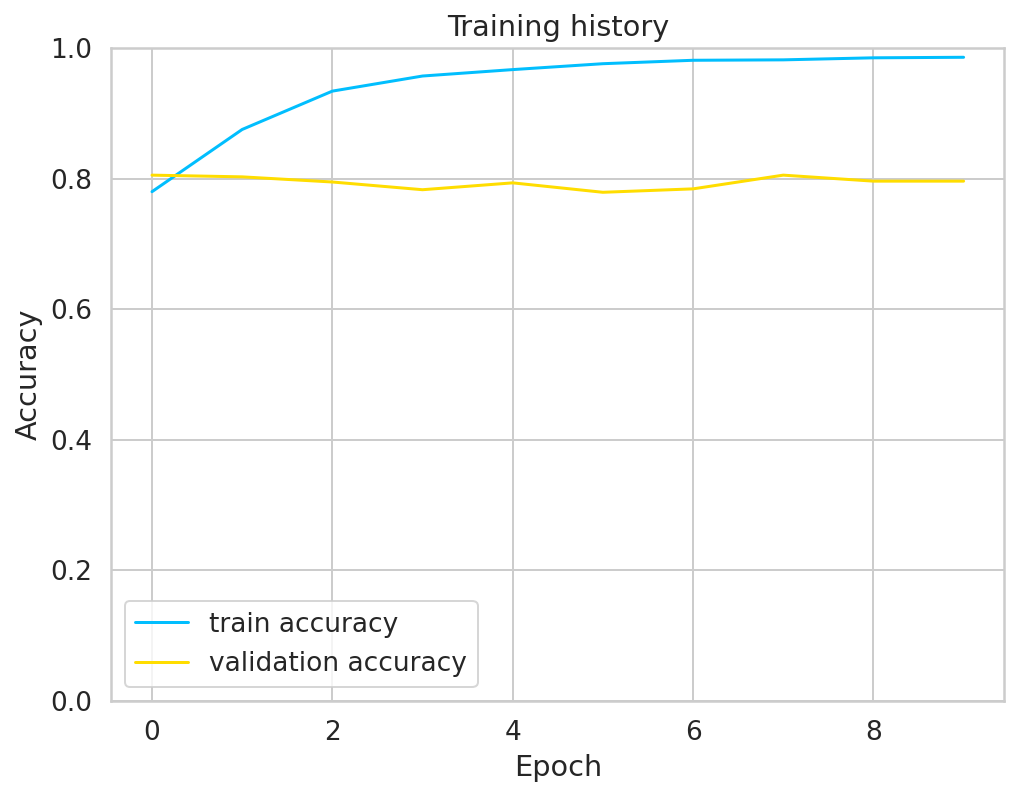

In [ ]:
#plots traing and validation history
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
#test accuracy
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.8162729658792651